In [24]:
import numpy as np
import pandas as pd
import wrds
import datetime
import matplotlib.pyplot as plt

In [61]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
db=wrds.Connection(wrds_username='hlanfran')


Loading library list...
Done


### (a)

### Get Data

In [44]:
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1980-01-01'"
            "and mcaldt<='2021-12-31'", date_cols=['mcaldt'])

Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


data_index=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1980-01-01'"
            "and date<='2021-12-31'", date_cols=['date'])


crsp_m = db.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.shrout, a.prc
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1980' and '12/31/2021'
                      and b.exchcd between 1 and 2
                      and b.shrcd between 10 and 11
                      """, date_cols=['date']) 

msf=crsp_m.drop(['shrcd','exchcd'],axis=1)

### clean data 

In [45]:
data=data[data.obs==504]
msf['permno'] = msf['permno'].astype(int)
msf.sort_values(['permno','date'])
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['const'] = 1

msf['size_lag']= msf.groupby('permno')['size'].shift(1).to_frame()

obs=msf[['const','permno']].groupby(['permno']).sum().reset_index().rename(columns={'const': 'obs'})
msf = pd.merge(msf, obs, how='left', left_on=['permno'],right_on=['permno'])

data_index = pd.merge(data_index, Rf, how='left', left_on=['date'],right_on='date')
data_index['mprem']=(data_index['vwretd']-data_index['rf'])
data = pd.merge(msf, data_index, how='left', left_on=['date'],right_on='date')
data['exret']=data['ret']-data['rf']

### (b)

In [87]:
def equal_weighted_average(grp, name, weight_name):
    d = grp[name]
    w = grp[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

covariances_all=data.groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar_all'})
var_all=data.groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'var_all'})
betas_all["betas_all"] = covariances_all["covar_all"]/var_all["var_all"]
data = pd.merge(data, betas_all, how='left', left_on=['permno'],right_on='permno')
data['decile']=1+data[['betas_all','date']].groupby('date').transform(lambda x: pd.qcut(x, 10, labels=False))

In [88]:
ret_all =data.groupby(['decile','date']).apply(equal_weighted_average, 'ret','const').to_frame().reset_index().rename(columns={0: 'ret_all'})
betas =data.groupby(['decile']).apply(equal_weighted_average, 'betas_all','const').to_frame().reset_index().rename(columns={0: 'betas_all_'})
ret_all_decile=ret_all.groupby(['decile']).mean().reset_index()


Text(0, 0.5, 'average return')

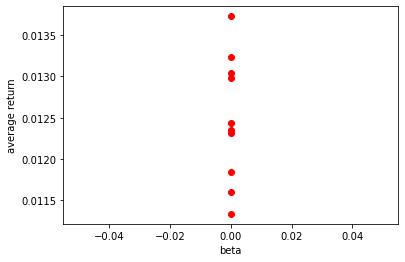

In [90]:
plt.plot(betas['betas_all_'].values,ret_all_decile['ret_all'].values,'ro')

plt.xlabel('beta')
plt.ylabel('average return')

### (c)

In [62]:
#out of sample data for second part
data['half']="oosd"
data.loc[data['date']<'01-01-2000','half']="isd"

#in sample data
covariances1=data[data['date']<'01-01-2000'].groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar1'})
mvar1=data[data['date']<'01-01-2000'].groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm1'})
#out of sample data
covariances2=data[data['date']>='01-01-2000'].groupby('permno')['exret'].cov(data['mprem']).to_frame().reset_index().rename(columns={'exret': 'covar2'})
mvar2=data[data['date']>='01-01-2000'].groupby('permno')['mprem'].var().to_frame().reset_index().rename(columns={'mprem': 'varm2'})

#merge new values with original dataset
betas = pd.merge(covariances1, mvar1, how='left', left_on=['permno'],right_on='permno')
betas = pd.merge(betas, covariances2, how='left', left_on=['permno'],right_on='permno')
betas = pd.merge(betas, mvar2, how='left', left_on=['permno'],right_on='permno')

# cumpute the betas
betas['beta1']=betas['covar1']/betas['varm1']
betas['beta2']=betas['covar2']/betas['varm2']

data= pd.merge(data, betas, how='left', left_on=['permno'],right_on='permno')

data = data.sort_values(['decile', 'date'])

data=data.set_index('date')  

# equally weigthed return
rets_oofd=data[data['half']=="oosd"].groupby(['decile','date']).apply(equal_weighted_average, 'ret','const').to_frame().reset_index().rename(columns={0: 'ewret'})

rets_isd=data[data['half']=="isd"].groupby(['decile']).apply(equal_weighted_average, 'beta1_x','const').to_frame().reset_index().rename(columns={0: 'beta1'})

betas_oofd=data[data['half']=="oosd"].groupby(['decile']).apply(equal_weighted_average, 'beta2_x','const').to_frame().reset_index().rename(columns={0: 'beta2'})

avgewrets2=rets_oofd.groupby(['decile']).mean().reset_index()

data=data.reset_index()

### plot returns against betas

Text(0, 0.5, 'average return')

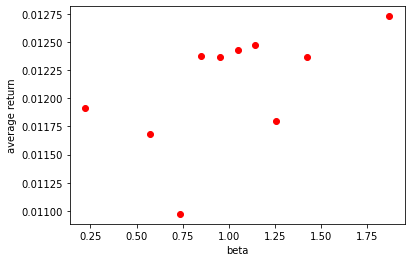

In [64]:
plt.plot(rets_isd['beta1'].values,rets_oofd['ewret'].values,'ro')

plt.xlabel('beta')
plt.ylabel('average return')

### plot betas

Text(0, 0.5, 'second-half beta')

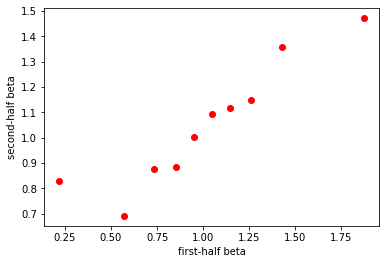

In [66]:
plt.plot(rets_isd['beta1'].values,betas_oofd['beta2'].values,'ro')

plt.xlabel('first-half beta')
plt.ylabel('second-half beta')


The samples are not very consistent accross the two periods.
The out of sample are still consitent with the CAPM nevertheless

### (d)

In [94]:
first_decile = data[data["decile"] == 1.0]
last_decile = data[data["decile"] == 10.0]

first_decile_std = first_decile["exret"].std()
first_decile_mean = first_decile["exret"].mean()

last_decile_std = last_decile["exret"].std()
last_decile_mean = last_decile["exret"].mean()

first_decile_SR = first_decile_mean/first_decile_std
last_decile_SR = last_decile_mean/last_decile_std

date
1980-01-31    1.0
1980-01-31    1.0
1980-01-31    1.0
1980-01-31    1.0
1980-01-31    1.0
             ... 
2021-12-31    NaN
2021-12-31    NaN
2021-12-31    NaN
2021-12-31    NaN
2021-12-31    NaN
Name: decile, Length: 965267, dtype: float64